### **Feature engineering**

#### **Import libraries**

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from pathlib import Path

from sklearn.feature_selection import mutual_info_regression

In [43]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [39]:
plt.style.use('ggplot')

#### **What is feature engineering?**

Feature engineering is used to make your data better suited to the probem at hand.

It is useful for the following reasons:

- Improve a model's predictive performance
- Reduce computational or data needs
- Improve interpretability 

It's interesting to point out that if a linear model is used when the true relationship is quadratic, it's possible to transform the features and not the model. 

First of all, a baseline model should be created in order to understand if the new features are useful.

In [4]:
dir_path = Path('fe-course-data/')

df = pd.read_csv(dir_path / 'concrete.csv')

In [5]:
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [6]:
df.shape

(1030, 9)

In [23]:
#--- Baseline model.

X = df.copy()
y = X.pop("CompressiveStrength")

baseline = RandomForestRegressor(criterion='mse', random_state=0)
baseline_score = cross_val_score(
    baseline,
    X, 
    y, 
    cv = 5,
    scoring = 'neg_mean_absolute_error'
)

baseline_score = -1 * baseline_score.mean()

print(f'MAE Baseline Model: {baseline_score:.4}')

c:\Users\Lucia\anaconda3\envs\github_env\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
c:\Users\Lucia\anaconda3\envs\github_env\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
c:\Users\Lucia\anaconda3\envs\github_env\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
c:\Users\Lucia\anaconda3\envs\github_env\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
c:\Users\Lucia\anaconda3\env

MAE Baseline Model: 8.137


In [24]:
#--- Add ratio of features: better result!

X = df.copy()
y = X.pop("CompressiveStrength")

X['FCRatio'] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

model = RandomForestRegressor(criterion = 'mae', random_state = 0)
score = cross_val_score(
    model,
    X, 
    y,
    cv = 5,
    scoring = 'neg_mean_absolute_error'
)

score = -1 * score.mean()

print(f'MAE Score with ratio features: {score:.4}')

c:\Users\Lucia\anaconda3\envs\github_env\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
c:\Users\Lucia\anaconda3\envs\github_env\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
c:\Users\Lucia\anaconda3\envs\github_env\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
c:\Users\Lucia\anaconda3\envs\github_env\lib\site-packages\sklearn\ensemble\_forest.py:403: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warn(
c:\Users\Lucia\anaconda3

MAE Score with ratio features: 7.948


#### **Mutual information**

Mutual information measures how variables are connected between each other not only in a linear way.

In other words, it describes the extent to which knowledge of one quantity reduces the uncertainty about the other; in this case, the former is a feature and the latter is the target. Moreover, the quantity that is measured by the MI is the entropy. 
Moreover, some characteristics are listed here:
- MI $\in [0, \infty]$: the lower bound means that the quantities are independent, otherwise there is a connection. 
- It's an _univariate_ features. 
- MI must be matched with the right model.  

In [25]:
dir_path = Path('fe-course-data/')

df = pd.read_csv(dir_path / 'autos.csv')

In [26]:
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


In [28]:
df.shape

(193, 25)

In [29]:
X = df.copy()
y = X.pop("price")

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

discrete_features = X.dtypes == int    

In [35]:
def make_mi_score(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features)
    mi_scores = pd.Series(mi_scores, index = X.columns, name = 'MI Scores')
    mi_scores = mi_scores.sort_values(ascending = False)

    return mi_scores

mi_scores = make_mi_score(X, y, discrete_features)  
mi_scores[:3]

curb_weight    0.914484
engine_size    0.907974
horsepower     0.885639
Name: MI Scores, dtype: float64

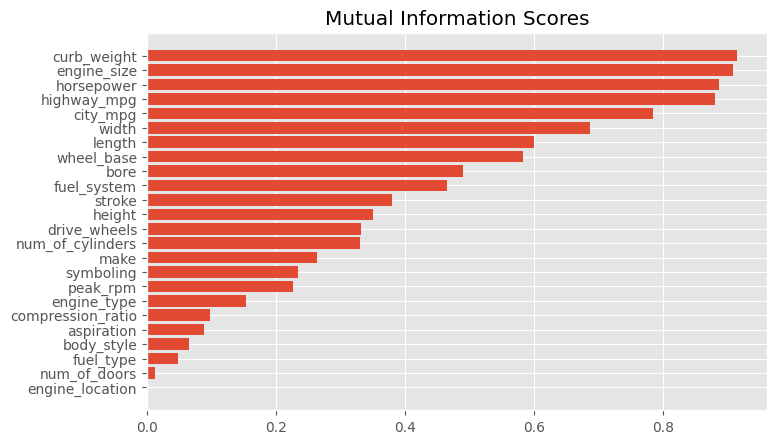

In [40]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

# Features which MI is high can be used to fit the model, while the one which have the lowest MI can be discarded.

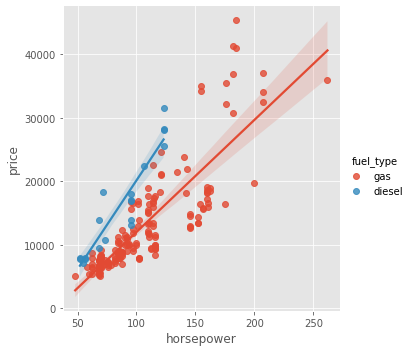

In [42]:
# However, it could be interesting to detect more about the fuel_type because,
# even if the MI is very low, it can be hide some information.  
# Indeed, it highlights the presence of a difference in the price derived by horsepower.


sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);

#### **Creating features**

Once features are filtered, some new features can be created. 

In [44]:
dir_path = Path('fe-course-data/')

accidents = pd.read_csv(dir_path / "accidents.csv")
autos = pd.read_csv(dir_path / "autos.csv")
concrete = pd.read_csv(dir_path / "concrete.csv")
customer = pd.read_csv(dir_path / "customer.csv")

In [ ]:
#  Car new feature from domain-knowledge.

autos["stroke_ratio"] = autos.stroke / autos.bore

autos[["stroke", "bore", "stroke_ratio"]].head()

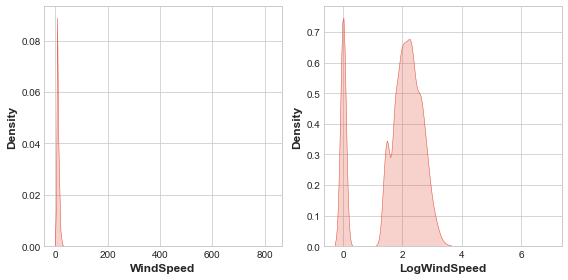

In [45]:
# High skewness feature.

# If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log.
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

# Plot a comparison.
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents.WindSpeed, shade=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=axs[1]);

In [46]:
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]
    
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)